In [31]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [114]:
num_dirs = 3
num_points = 100

true_dirs = torch.rand(num_dirs, 2) - torch.rand(num_dirs, 2)
true_dirs = true_dirs/torch.norm(true_dirs, dim=1).unsqueeze(1)

X = torch.zeros(num_dirs, num_points, 2)

for i in range(num_dirs):
    t = torch.rand((num_points)).unsqueeze(1)
    X[i] = t * true_dirs[i] + torch.randn((num_points, 2))/100 # (10, 2)

X = X.view(-1, 2)

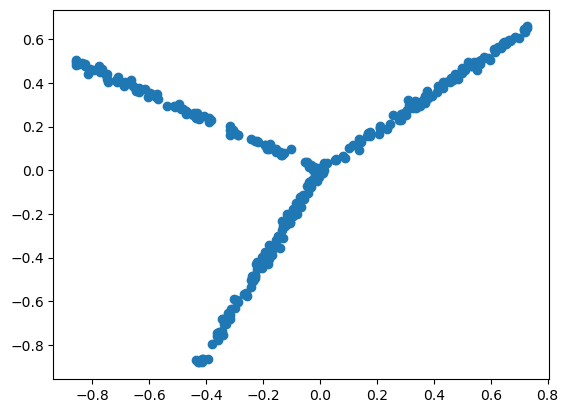

In [115]:
plt.scatter(X[:, 0], X[:, 1])

In [116]:
class AutoEncoder(nn.Module):
    def __init__(self, act_size, num_features):
        super().__init__()

        self.num_features = num_features

        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(act_size, num_features)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(num_features, act_size)))
        self.b_enc = nn.Parameter(torch.zeros(num_features))
        self.b_dec = nn.Parameter(torch.zeros(act_size))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
    
    def forward(self, x):
        x_cent = x - self.b_dec
        
        #acts = F.relu(x_cent @ self.W_enc + self.b_enc) # (B, num_features)
        pre_acts = x_cent @ self.W_enc + self.b_enc # (B, num_features)
        topk = torch.topk(pre_acts, k=1, dim=1)

        acts = torch.zeros_like(pre_acts)
        acts.scatter_(-1, topk.indices, F.relu(topk.values))

        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        loss = l2_loss
        return loss, x_reconstruct, acts, l2_loss
    
    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        self.W_dec.data = W_dec_normed

In [121]:
sae = AutoEncoder(act_size=2, num_features=2*num_dirs)
optim = torch.optim.AdamW(sae.parameters(), lr=1e-3)

In [122]:
for i in range(10000):
    loss, x_reconstruct, features, l2_loss = sae(X)
    loss.backward()
    sae.make_decoder_weights_and_grad_unit_norm()
    optim.step()
    optim.zero_grad()
    
    if i%1000==0:
        print(f"loss : {loss.item()}")

print(torch.max(features, dim=0).values)

loss : 0.2942671775817871
loss : 0.024909498170018196
loss : 0.005668649449944496
loss : 0.000155478177475743
loss : 9.740934910951182e-05
loss : 9.719754598336294e-05
loss : 9.715580381453037e-05
loss : 9.71343761193566e-05
loss : 9.71231929725036e-05
loss : 9.711692109704018e-05
tensor([0.0000, 0.9809, 0.9799, 0.9942, 0.0000, 0.0000],
       grad_fn=<MaxBackward0>)


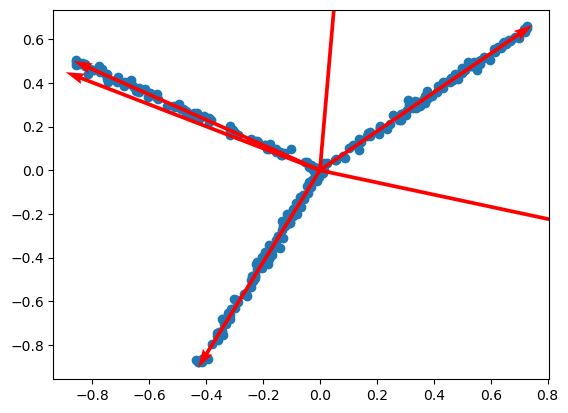

In [123]:
plt.scatter(X[:, 0], X[:, 1])

vectors = sae.W_dec.detach().numpy()
plt.quiver(np.zeros((sae.num_features)), np.zeros((sae.num_features)), vectors[:, 0], vectors[:, 1], scale=1, scale_units='xy', angles='xy', color='red')